In [1]:
%matplotlib inline
import nivapy3 as nivapy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
import sys
from IPython.display import display

# warnings.simplefilter('ignore')
plt.style.use("ggplot")

In [2]:
# CL functions not yet in NivaPy
sys.path.append("/home/jovyan/projects/critical_loads_2/notebooks")
import critical_loads as cl

In [3]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis(database="critical_loads")

Connection successful.


# 1000 Lakes 2019 (Part 3: Process NILU deposition data)

This notebook extracts atmospheric deposition data provided by NILU from the Critical Loads database.

## 1. Get station co-ordinates 

The relevant project ID in RESA is 4530.

In [4]:
# Read RESA co-ords
csv_path = r"../output/resa_1000_lakes_stn_list.csv"
stn_df = pd.read_csv(csv_path)

stn_df.head()

,station_id,station_code,station_name,latitude,longitude,altitude
0,3167,620-4-6,Ørteren,60.470,7.795,1147.0
1,3168,621-1-27,Flåvatna,60.200,9.183,855.0
2,3169,621-3-5,Soneren,60.061,9.545,104.0
3,3170,622-2-43,Trytetjern,60.213,9.764,275.0
4,3171,622-4-4,Krøderen,60.327,9.645,133.0


## 2. Extract deposition data

We're interested in the "Middel" data using the BLR grid. See e-mail from Kari received 26.05.2020 at 11.00.

In [5]:
# Show series already in database
with pd.option_context("display.max_colwidth", -1):
    ser_grid = cl.view_dep_series(eng)

    # Just data of interest
    ser_grid = ser_grid.query("grid == 'blr'")

    display(ser_grid)

,series_id,name,short_name,grid,description
0,1,Middel 1978-1982,7882,blr,Fordelt til BLR av NILU 2002
1,2,Middel 1992-1996,9296,blr,Fordelt til BLR av NILU 2002
2,3,Middel 1997-2001,9701,blr,Fordelt til BLR av NILU 2002
3,4,Middel 2002-2006,0206,blr,Fordelt til BLR av NILU 2008 (Wenche Aas)
24,25,Middel 2007-2011,0711,blr,Fordelt til BLR av NILU 2012 (Wenche Aas)
25,26,Middel 2012-2016,1216_old,blr,Fordelt til BLR av NILU 2017 (Wenche Aas; old method)
26,27,Middel 2012-2016 (new),1216_blrgrid,blr,Fordelt til BLR av NILU 2017 (Wenche Aas; new method)
28,29,Middel 1983-1987,8387,blr,Fordelt til BLR av NILU 2019 (Wenche Aas; old method)
29,30,Middel 1988-1992,8892,blr,Fordelt til BLR av NILU 2019 (Wenche Aas; old method)


Based on this, the relevant "short names" are `9296`, `9701`, `0206`, `0711` and `1216_old` (we're using the "old" method for 2012 - 20166 so that the results are compatible with previous time periods).

In [6]:
# Get BLR cell ID for stations
n_gdf = cl.extract_deposition_as_gdf(2, "nitrogen", eng)

# Rename 'geom' to 'geometry' (will not be necessary with latest NivaPy)
n_gdf.rename({'geom':'geometry'}, inplace=True, axis=1)
n_gdf.set_geometry('geometry', inplace=True)

# Get cell IDs
stn_df = nivapy.spatial.identify_point_in_polygon(
    stn_df,
    n_gdf,
    pt_col="station_id",
    poly_col="cell_id",
    lat_col="latitude",
    lon_col="longitude",
)

stn_df.head()

/home/jovyan/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,station_id,station_code,station_name,latitude,longitude,altitude,cell_id
0,3167,620-4-6,Ørteren,60.470,7.795,1147.0,60007004.0
1,3168,621-1-27,Flåvatna,60.200,9.183,855.0,60009009.0
2,3169,621-3-5,Soneren,60.061,9.545,104.0,60009015.0
3,3170,622-2-43,Trytetjern,60.213,9.764,275.0,60009012.0
4,3171,622-4-4,Krøderen,60.327,9.645,133.0,60009007.0


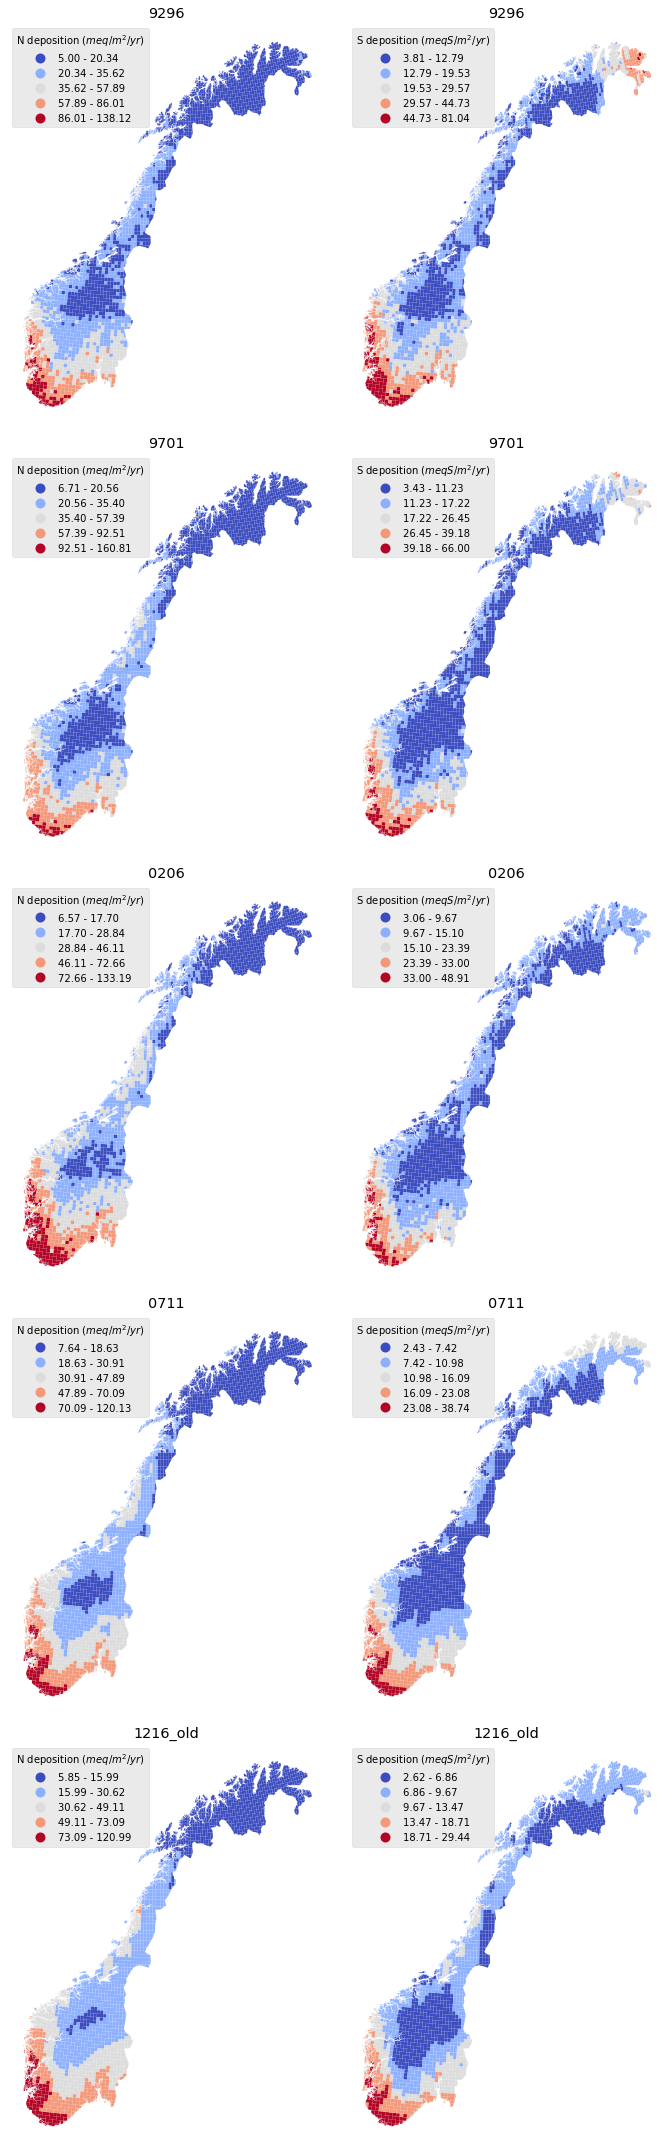

In [7]:
# Get deposition data
short_names = ["9296", "9701", "0206", "0711", "1216_old"]

# Plotting
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 30))

for idx, name in enumerate(short_names):
    series_id = int(ser_grid.query("short_name == @name")["series_id"].values[0])

    # Get dep data
    n_gdf = cl.extract_deposition_as_gdf(series_id, "nitrogen", eng)
    s_gdf = cl.extract_deposition_as_gdf(series_id, "sulphur", eng)
    
    # Plot
    n_gdf.plot(column='ndep_meqpm2pyr', 
               cmap='coolwarm',
               scheme='fisher_jenks',
               edgecolor=None,
               legend=True,
               legend_kwds={'loc':   'upper left',
                            'title': 'N deposition ($meq/m^2/yr$)'},
               ax=axes[idx, 0],
              )
    axes[idx, 0].set_title(name)
    
    s_gdf.plot(column='sdep_meqpm2pyr', 
           cmap='coolwarm',
           scheme='fisher_jenks',
           edgecolor=None,
           legend=True,
           legend_kwds={'loc':   'upper left',
                        'title': 'S deposition ($meqS/m^2/yr$)'},
           ax=axes[idx, 1],
          )
    axes[idx, 1].set_title(name)

    # Tidy
    n_gdf = n_gdf[['cell_id', 'ndep_meqpm2pyr']]
    n_gdf.columns = ['cell_id', f'{name}_ndep_meqpm2pyr']

    s_gdf = s_gdf[['cell_id', 'sdep_meqpm2pyr']]
    s_gdf.columns = ['cell_id', f'{name}_sdep_meqpm2pyr']
    
    # Join to result
    stn_df = pd.merge(stn_df, n_gdf, how='left', on='cell_id')
    stn_df = pd.merge(stn_df, s_gdf, how='left', on='cell_id')
    
[ax.set_axis_off() for ax in axes.flatten()]
plt.tight_layout()

In [8]:
# Save
csv_path = r'../output/1000_lakes_n_s_dep.csv'
stn_df.to_csv(csv_path, index=False)
stn_df.head()

,station_id,station_code,station_name,latitude,longitude,altitude,cell_id,9296_ndep_meqpm2pyr,9296_sdep_meqpm2pyr,9701_ndep_meqpm2pyr,9701_sdep_meqpm2pyr,0206_ndep_meqpm2pyr,0206_sdep_meqpm2pyr,0711_ndep_meqpm2pyr,0711_sdep_meqpm2pyr,1216_old_ndep_meqpm2pyr,1216_old_sdep_meqpm2pyr
0,3167,620-4-6,Ørteren,60.470,7.795,1147.0,60007004.0,26.481085,14.909545,22.198430,10.355583,24.910778,10.043668,28.551035,9.232689,29.621699,6.674984
1,3168,621-1-27,Flåvatna,60.200,9.183,855.0,60009009.0,35.902926,20.024953,35.189151,14.971928,28.122769,10.293200,33.476089,10.355583,35.546039,7.922645
2,3169,621-3-5,Soneren,60.061,9.545,104.0,60009015.0,59.885796,33.749220,59.885796,25.826575,50.107066,18.153462,38.686652,11.977542,41.184868,9.419838
3,3170,622-2-43,Trytetjern,60.213,9.764,275.0,60009012.0,39.757316,22.145976,38.401142,16.094822,40.256959,14.160948,35.046395,10.605115,40.042827,8.920774
4,3171,622-4-4,Krøderen,60.327,9.645,133.0,60009007.0,25.196288,14.223331,24.553890,10.417966,25.053533,9.232689,34.903640,10.667498,36.616702,8.671241


## 3. Add to database

It is not currently possible to connect to RESA from JupyterHub, due to NIVA's firewall blocking the connection. **The code below must therefore be run locally via Docker**.

### 3.1. Add metadata parameters to database

I have created new entries in the `station_parameter_definitions` table in RESA, as shown below:

| VAR_ID |                 VAR_NAME                 |    UNIT   | TYPE |                          EXPLANATION                         | CATEGORY | ENTERED_BY | ENTERED_DATE |
|:------:|:----------------------------------------:|:---------:|:----:|:------------------------------------------------------------:|:--------:|:----------:|:------------:|
|   350  | NILU mean total N deposition 1992 - 1996 | meq/m2/yr |   n  |  Supplied by NILU using BLR grid; series_id 2 in CL database |     2    |    JES     |  27.05.2020  |
|   351  | NILU mean total S deposition 1992 - 1996 | meq/m2/yr |   n  |  Supplied by NILU using BLR grid; series_id 2 in CL database |     2    |    JES     |  27.05.2020  |
|   352  | NILU mean total N deposition 2012 - 2016 | meq/m2/yr |   n  | Supplied by NILU using BLR grid; series_id 26 in CL database |     2    |    JES     |  27.05.2020  |
|   353  | NILU mean total S deposition 2012 - 2016 | meq/m2/yr |   n  | Supplied by NILU using BLR grid; series_id 26 in CL database |     2    |    JES     |  27.05.2020  |

### 3.2. Extract data of interest

In [5]:
# Read data saved above
csv_path = r'../output/1000_lakes_n_s_dep.csv'
stn_df = pd.read_csv(csv_path)

# Get cols of interest
to_remove = ['station_code', 'station_name', 'latitude', 'longitude', 'altitude', 'cell_id']
to_keep = [i for i in stn_df.columns if i not in to_remove]
dep_df = stn_df[to_keep]

# Melt
dep_df = dep_df.melt(id_vars='station_id')

# Map for par IDs
par_dict = {'9296_ndep_meqpm2pyr': 350,
            '9296_sdep_meqpm2pyr': 351,
            '1216_old_ndep_meqpm2pyr': 352,
            '1216_old_sdep_meqpm2pyr': 353,
           }

# Just data of interest
dep_df = dep_df.query("variable in @par_dict.keys()")

dep_df['var_id'] = dep_df['variable'].replace(par_dict)
dep_df = dep_df[['station_id', 'var_id', 'value']]
dep_df = dep_df.dropna()

dep_df.head()

,station_id,var_id,value
0,3167,350,26.481085
1,3168,350,35.902926
2,3169,350,59.885796
3,3170,350,39.757316
4,3171,350,25.196288


### 3.3. Add to database

In [6]:
# Connect to RESA
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


In [7]:
#dep_df.to_sql(
#   "stations_par_values",
#   schema="resa2",
#   con=eng,
#   if_exists="append",
#   index=False,
#)